<a href="https://colab.research.google.com/github/marta4cod/NNProject2/blob/main/NN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
import string, re

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    BertConfig,
    BertForQuestionAnswering
)


In [3]:
###############################################################################
# CONFIG
###############################################################################
TEACHER_MODEL_NAME = "bert-large-uncased-whole-word-masking-finetuned-squad"
MAX_LENGTH = 384
BATCH_SIZE = 8
EPOCHS = 2  # Increase for better results
LEARNING_RATE = 3e-5

# Distillation hyperparams
ALPHA = 0.5        # Weight of soft (teacher) loss
TEMPERATURE = 3.0  # Temperature for soft logits

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


In [5]:

###############################################################################
# 1) DATA LOADING & PREPROCESSING
###############################################################################
raw_squad = load_dataset("squad")

# For demonstration, we'll use the full training set or a subset
train_data = raw_squad["train"]
val_data = raw_squad["validation"].select(range(1000))
#train_data = raw_squad["train"].select(range(1000))       # 1k examples
#val_data   = raw_squad["validation"].select(range(200))   # 200 examples

tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME, use_fast=True)

def preprocess_function(ex):
    """
    Tokenize question + context and try to map answer start/end to token indices.
    We'll do a naive single-chunk approach (no sliding window).
    """
    # SQuAD "answers" has a list of possible answers; we take the first
    start_char = ex["answers"]["answer_start"][0]
    ans_texts = ex["answers"]["text"]
    answer_text = ans_texts[0] if len(ans_texts) > 0 else ""

    encoding = tokenizer(
        ex["question"],
        ex["context"],
        max_length=MAX_LENGTH,
        padding="max_length",
        truncation=True,
        return_offsets_mapping=True  # We'll use offsets for naive char->token mapping
    )

    offsets = encoding["offset_mapping"]
    input_ids = encoding["input_ids"]

    # Find start/end token indices
    start_token_idx = 0
    end_token_idx = 0

    # End char
    end_char = start_char + len(answer_text)

    # loop through offsets to find the best match
    for i, (off_start, off_end) in enumerate(offsets):
        # Some offsets may be None or special tokens
        if off_start is None or off_end is None:
            continue
        if off_start <= start_char < off_end:
            start_token_idx = i
        if off_start < end_char <= off_end:
            end_token_idx = i
            break

    if end_token_idx < start_token_idx:
        end_token_idx = start_token_idx

    # Store in encoding
    encoding["start_positions"] = start_token_idx
    encoding["end_positions"] = end_token_idx

    # Remove offset mapping to reduce data size
    encoding.pop("offset_mapping")

    return encoding

train_processed = train_data.map(preprocess_function)
val_processed   = val_data.map(preprocess_function)

# We'll convert to PyTorch Tensors
def to_tensor_dataset(hf_dataset):
    input_ids = torch.tensor(hf_dataset["input_ids"], dtype=torch.long)
    attention_mask = torch.tensor(hf_dataset["attention_mask"], dtype=torch.long)
    token_type_ids = torch.tensor(hf_dataset["token_type_ids"], dtype=torch.long) \
        if "token_type_ids" in hf_dataset.features else None
    start_positions = torch.tensor(hf_dataset["start_positions"], dtype=torch.long)
    end_positions   = torch.tensor(hf_dataset["end_positions"], dtype=torch.long)

    if token_type_ids is not None:
        return TensorDataset(input_ids, attention_mask, token_type_ids, start_positions, end_positions)
    else:
        # For models without token_type_ids (like DistilBERT)
        return TensorDataset(input_ids, attention_mask, start_positions, end_positions)

train_tds = to_tensor_dataset(train_processed)
val_tds   = to_tensor_dataset(val_processed)

train_loader = DataLoader(train_tds, batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_tds,   batch_size=BATCH_SIZE, shuffle=False)


Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [6]:
###############################################################################
# 2) TEACHER MODEL INFERENCE (collect teacher logits)
###############################################################################
teacher_model = AutoModelForQuestionAnswering.from_pretrained(TEACHER_MODEL_NAME).to(DEVICE)
teacher_model.eval()

teacher_start_logits_list = []
teacher_end_logits_list   = []
gt_start_list = []
gt_end_list   = []
input_tensors = []
count=0
with torch.no_grad():
    for batch in train_loader:
      count+=1
      print("batch", count)
      # batch can have 4 or 5 tensors depending on token_type_ids existence
      if len(batch) == 5:
          input_ids, attention_mask, token_type_ids, start_pos, end_pos = batch
          token_type_ids = token_type_ids.to(DEVICE)
      else:
          input_ids, attention_mask, start_pos, end_pos = batch
          token_type_ids = None

      input_ids = input_ids.to(DEVICE)
      attention_mask = attention_mask.to(DEVICE)
      start_pos = start_pos.to(DEVICE)
      end_pos   = end_pos.to(DEVICE)

      outputs = teacher_model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      # Collect logits
      teacher_start_logits_list.append(outputs.start_logits.cpu())
      teacher_end_logits_list.append(outputs.end_logits.cpu())

      gt_start_list.append(start_pos.cpu())
      gt_end_list.append(end_pos.cpu())

      # We'll store the CPU tensors of inputs for the student dataset
      if token_type_ids is not None:
          input_tensors.append((input_ids.cpu(), attention_mask.cpu(), token_type_ids.cpu()))
      else:
          # Rare for BERT-based QA to not have token_type_ids, but just in case:
          # We'll store None in place of token_type_ids.
          input_tensors.append((input_ids.cpu(), attention_mask.cpu(), None))

# Concatenate teacher outputs
teacher_start_logits_full = torch.cat(teacher_start_logits_list, dim=0)
teacher_end_logits_full   = torch.cat(teacher_end_logits_list, dim=0)
gt_start_full = torch.cat(gt_start_list, dim=0)
gt_end_full   = torch.cat(gt_end_list, dim=0)

# Flatten input tensors
all_input_ids         = []
all_attention_masks   = []
all_token_type_ids    = []
for batch_data in input_tensors:
    i_ids, i_mask, i_type = batch_data
    all_input_ids.append(i_ids)
    all_attention_masks.append(i_mask)
    if i_type is not None:
        all_token_type_ids.append(i_type)
    else:
        # If there's no token_type_ids, we store None
        all_token_type_ids = None

all_input_ids       = torch.cat(all_input_ids, dim=0)
all_attention_masks = torch.cat(all_attention_masks, dim=0)
if all_token_type_ids is not None and len(all_token_type_ids) > 0:
    all_token_type_ids = torch.cat(all_token_type_ids, dim=0)

print("Teacher logits shapes:")
print("  start_logits:", teacher_start_logits_full.shape)
print("  end_logits:  ", teacher_end_logits_full.shape)
print("Ground truth shapes:", gt_start_full.shape, gt_end_full.shape)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Streaming output truncated to the last 5000 lines.
batch 5955
batch 5956
batch 5957
batch 5958
batch 5959
batch 5960
batch 5961
batch 5962
batch 5963
batch 5964
batch 5965
batch 5966
batch 5967
batch 5968
batch 5969
batch 5970
batch 5971
batch 5972
batch 5973
batch 5974
batch 5975
batch 5976
batch 5977
batch 5978
batch 5979
batch 5980
batch 5981
batch 5982
batch 5983
batch 5984
batch 5985
batch 5986
batch 5987
batch 5988
batch 5989
batch 5990
batch 5991
batch 5992
batch 5993
batch 5994
batch 5995
batch 5996
batch 5997
batch 5998
batch 5999
batch 6000
batch 6001
batch 6002
batch 6003
batch 6004
batch 6005
batch 6006
batch 6007
batch 6008
batch 6009
batch 6010
batch 6011
batch 6012
batch 6013
batch 6014
batch 6015
batch 6016
batch 6017
batch 6018
batch 6019
batch 6020
batch 6021
batch 6022
batch 6023
batch 6024
batch 6025
batch 6026
batch 6027
batch 6028
batch 6029
batch 6030
batch 6031
batch 6032
batch 6033
batch 6034
batch 6035
batch 6036
batch 6037
batch 6038
batch 6039
batch 6040
bat

In [8]:
####  IMPORTANT ######
# This step is done once to save logits on Drive for faster loading in the future.
# Saved teacher logits and data to: /content/drive/MyDrive/teacher_logits_data.pt

# 2a) SAVE TEACHER LOGITS & INPUTS

import torch

from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/teacher_logits_data.pt"

torch.save({
    "start_logits": teacher_start_logits_full,
    "end_logits": teacher_end_logits_full,
    "gt_start": gt_start_full,
    "gt_end": gt_end_full,
    "input_ids": all_input_ids,
    "attention_mask": all_attention_masks,
    "token_type_ids": all_token_type_ids
}, save_path)

print(f"✅ Saved teacher logits and data to: {save_path}")


Mounted at /content/drive
✅ Saved teacher logits and data to: /content/drive/MyDrive/teacher_logits_data.pt


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# 2b) LOAD SAVED LOGITS & INPUTS

import torch

load_path = "teacher_logits_data.pt"
data = torch.load(load_path)

teacher_start_logits_full = data["start_logits"]
teacher_end_logits_full   = data["end_logits"]
gt_start_full             = data["gt_start"]
gt_end_full               = data["gt_end"]
all_input_ids             = data["input_ids"]
all_attention_masks       = data["attention_mask"]
all_token_type_ids        = data["token_type_ids"]

print(f"✅ Loaded teacher logits and input data from: {load_path}")

In [ ]:

###############################################################################
# 3) DEFINE A SMALLER STUDENT MODEL
###############################################################################
student_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=384,         # smaller hidden dim
    num_hidden_layers=8,     # fewer layers
    num_attention_heads=8,   # fewer heads
    intermediate_size=384 * 4,
    max_position_embeddings=MAX_LENGTH
)
student_model = BertForQuestionAnswering(student_config).to(DEVICE)

In [ ]:
###############################################################################
# 4) DISTILLATION TRAINING
###############################################################################
# We'll build a custom dataset that yields inputs & teacher (soft) + ground-truth (hard)
# We'll store teacher's probabilities (soft targets) with a temperature-based softmax.

def softmax_with_temperature(logits, temperature=TEMPERATURE):
    # logits: [batch_size, seq_len]
    return F.softmax(logits / temperature, dim=-1)

teacher_start_probs = softmax_with_temperature(teacher_start_logits_full, TEMPERATURE)
teacher_end_probs   = softmax_with_temperature(teacher_end_logits_full,   TEMPERATURE)

class DistillationDataset(Dataset):
    def __init__(self, input_ids, attention_mask, token_type_ids,
                 teacher_start_probs, teacher_end_probs,
                 gt_start, gt_end):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.teacher_start_probs = teacher_start_probs
        self.teacher_end_probs   = teacher_end_probs
        self.gt_start = gt_start
        self.gt_end   = gt_end

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        if self.token_type_ids is not None:
            return (
                self.input_ids[idx],
                self.attention_mask[idx],
                self.token_type_ids[idx],
                self.teacher_start_probs[idx],
                self.teacher_end_probs[idx],
                self.gt_start[idx],
                self.gt_end[idx],
            )
        else:
            # If no token_type_ids exist
            return (
                self.input_ids[idx],
                self.attention_mask[idx],
                None,
                self.teacher_start_probs[idx],
                self.teacher_end_probs[idx],
                self.gt_start[idx],
                self.gt_end[idx],
            )

distill_dataset = DistillationDataset(
    all_input_ids, all_attention_masks, all_token_type_ids,
    teacher_start_probs, teacher_end_probs,
    gt_start_full, gt_end_full
)
distill_loader = DataLoader(distill_dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = torch.optim.AdamW(student_model.parameters(), lr=LEARNING_RATE)

def distillation_train_step(batch_data):
    if all_token_type_ids is not None:
        input_ids, attention_mask, token_type_ids, t_start_probs, t_end_probs, gt_start, gt_end = batch_data
        token_type_ids = token_type_ids.to(DEVICE)
    else:
        input_ids, attention_mask, _, t_start_probs, t_end_probs, gt_start, gt_end = batch_data
        token_type_ids = None

    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    t_start_probs = t_start_probs.to(DEVICE)
    t_end_probs   = t_end_probs.to(DEVICE)
    gt_start = gt_start.to(DEVICE)
    gt_end   = gt_end.to(DEVICE)

    optimizer.zero_grad()
    outputs = student_model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )
    student_start_logits = outputs.start_logits
    student_end_logits   = outputs.end_logits

    # 1) Hard loss (CE with ground truth)
    ce_loss_fn = nn.CrossEntropyLoss()
    loss_start_hard = ce_loss_fn(student_start_logits, gt_start)
    loss_end_hard   = ce_loss_fn(student_end_logits,   gt_end)
    hard_loss = 0.5 * (loss_start_hard + loss_end_hard)

    # 2) Soft loss (KL divergence with teacher distribution)
    # Convert student logits to probabilities with same temperature
    s_start_probs = softmax_with_temperature(student_start_logits, TEMPERATURE)
    s_end_probs   = softmax_with_temperature(student_end_logits,   TEMPERATURE)

    # We'll use KLDivLoss (expects log probs for input by default)
    kl_loss_fn = nn.KLDivLoss(reduction="batchmean")
    start_kl = kl_loss_fn(s_start_probs.log(), t_start_probs)  # KL(student||teacher)
    end_kl   = kl_loss_fn(s_end_probs.log(),   t_end_probs)
    soft_loss = 0.5 * (start_kl + end_kl)

    loss = ALPHA * soft_loss + (1 - ALPHA) * hard_loss
    loss.backward()
    optimizer.step()

    return loss.item(), hard_loss.item(), soft_loss.item()

em_epoch_scores = []
f1_epoch_scores = []

# Run distillation training
for epoch in range(EPOCHS):
    print(f"\n=== EPOCH {epoch+1}/{EPOCHS} ===")
    epoch_losses = []
    for step, batch_data in enumerate(distill_loader):
        loss_val, hard_val, soft_val = distillation_train_step(batch_data)
        epoch_losses.append(loss_val)
        if step % 200 == 0:
            print(f" Step {step} - Distill Loss: {loss_val:.4f} (Hard: {hard_val:.4f}, Soft: {soft_val:.4f})")
    print(f" Average Loss: {np.mean(epoch_losses):.4f}")

    # Run validation after each epoch
    avg_em = np.mean(em_epoch_scores) * 100
    avg_f1 = np.mean(f1_epoch_scores) * 100
    em_scores.append(avg_em)
    f1_scores.append(avg_f1

    print(f"Validation Results (Epoch {epoch+1}):")
    print(f"  Exact Match: {avg_em:.2f}%")
    print(f"  F1 Score:    {avg_f1:.2f}%")


=== EPOCH 1/2 ===
 Step 0 - Distill Loss: 2.7338 (Hard: 4.4899, Soft: 0.9777)
 Step 200 - Distill Loss: 2.6468 (Hard: 4.4706, Soft: 0.8230)
 Step 400 - Distill Loss: 2.7171 (Hard: 4.3647, Soft: 1.0695)
 Step 600 - Distill Loss: 2.9143 (Hard: 4.7940, Soft: 1.0347)
 Step 800 - Distill Loss: 2.6879 (Hard: 4.3480, Soft: 1.0278)
 Step 1000 - Distill Loss: 2.7585 (Hard: 4.3833, Soft: 1.1338)
 Step 1200 - Distill Loss: 3.0853 (Hard: 5.0847, Soft: 1.0858)
 Step 1400 - Distill Loss: 2.6052 (Hard: 4.2156, Soft: 0.9949)
 Step 1600 - Distill Loss: 2.6030 (Hard: 4.2449, Soft: 0.9610)
 Step 1800 - Distill Loss: 2.8185 (Hard: 4.4952, Soft: 1.1418)
 Step 2000 - Distill Loss: 2.5269 (Hard: 3.9605, Soft: 1.0932)
 Step 2200 - Distill Loss: 2.5233 (Hard: 4.1126, Soft: 0.9341)
 Step 2400 - Distill Loss: 2.7130 (Hard: 4.4596, Soft: 0.9663)
 Step 2600 - Distill Loss: 2.6084 (Hard: 4.1970, Soft: 1.0199)
 Step 2800 - Distill Loss: 2.6783 (Hard: 4.3870, Soft: 0.9697)
 Step 3000 - Distill Loss: 2.7247 (Hard: 4.

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 Step 200 - Distill Loss: 2.5516 (Hard: 4.1402, Soft: 0.9630)
 Step 400 - Distill Loss: 1.9744 (Hard: 3.0962, Soft: 0.8525)
 Step 600 - Distill Loss: 2.5197 (Hard: 4.1366, Soft: 0.9027)
 Step 800 - Distill Loss: 2.5121 (Hard: 4.0043, Soft: 1.0199)
 Step 1000 - Distill Loss: 2.4362 (Hard: 4.0203, Soft: 0.8520)
 Step 1200 - Distill Loss: 2.5481 (Hard: 4.2224, Soft: 0.8739)
 Step 1400 - Distill Loss: 2.7078 (Hard: 4.2695, Soft: 1.1462)
 Step 1600 - Distill Loss: 1.7911 (Hard: 2.7078, Soft: 0.8743)
 Step 1800 - Distill Loss: 2.3710 (Hard: 3.6853, Soft: 1.0567)
 Step 2000 - Distill Loss: 2.4506 (Hard: 4.0243, Soft: 0.8770)
 Step 2200 - Distill Loss: 1.9870 (Hard: 3.2364, Soft: 0.7375)
 Step 2400 - Distill Loss: 2.4042 (Hard: 3.7761, Soft: 1.0323)
 Step 2600 - Distill Loss: 2.3731 (Hard: 3.8747, Soft: 0.8714)
 Step 2800 - Distill Loss: 2.4455 (Hard: 4.0782, Soft: 0.8129)
 Step 3000 - Distill Loss: 2.6473 (Hard: 4.4545, Soft: 0.8401)
 Step 3200 - Distill Loss: 2.7435 (Hard: 4.4566, Soft: 1.03

In [7]:
print(f1_scores)
print(em_scores)

NameError: name 'f1_scores' is not defined

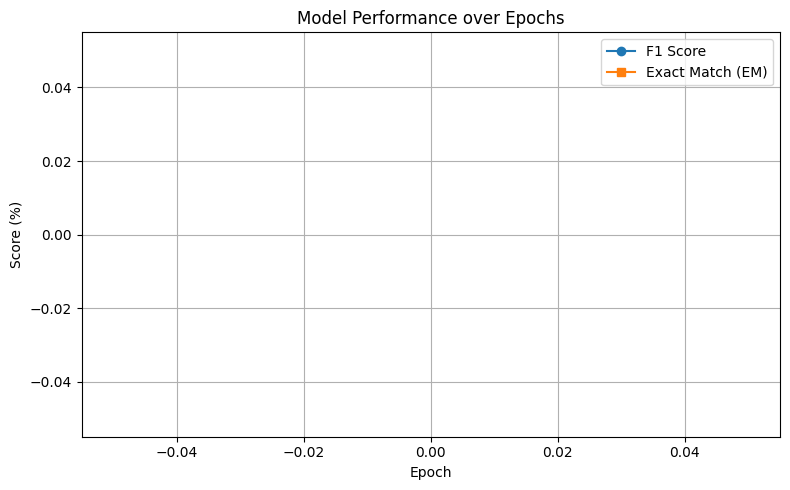

In [ ]:
import matplotlib.pyplot as plt

epoch_range = list(range(1, EPOCHS + 1))

plt.figure(figsize=(8, 5))
plt.plot(epoch_range, f1_scores, label="F1 Score", marker='o')
plt.plot(epoch_range, em_scores, label="Exact Match (EM)", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Score (%)")
plt.title("Model Performance over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:


###############################################################################
# 5) POST-PROCESSING & EVALUATION
###############################################################################
# We'll do a naive approach: take argmax of start/end, decode, compare with ground truth.
val_contexts = val_data["context"]
val_questions = val_data["question"]
val_answers = val_data["answers"]  # list of dicts with "text", "answer_start"

def normalize_text(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(txt):
        return re.sub(r"\b(a|an|the)\b", " ", txt)
    def remove_punc(txt):
        return "".join(ch for ch in txt if ch not in string.punctuation)

    s = s.lower()
    s = remove_articles(s)
    s = remove_punc(s)
    s = " ".join(s.split())
    return s

def compute_exact_match(pred, truth):
    return int(normalize_text(pred) == normalize_text(truth))

def compute_f1(pred, truth):
    pred_tokens = normalize_text(pred).split()
    truth_tokens = normalize_text(truth).split()
    common = set(pred_tokens) & set(truth_tokens)
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    if len(common) == 0:
        return 0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

student_model.eval()
em_scores = []
f1_scores = []

val_dataloader = DataLoader(val_tds, batch_size=8, shuffle=False)
offset = 0  # to track the global index in val_data
with torch.no_grad():
    for batch in val_dataloader:
        if len(batch) == 5:
            input_ids, attention_mask, token_type_ids, start_pos, end_pos = batch
            token_type_ids = token_type_ids.to(DEVICE)
        else:
            input_ids, attention_mask, start_pos, end_pos = batch
            token_type_ids = None

        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)

        outputs = student_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        start_logits = outputs.start_logits
        end_logits   = outputs.end_logits

        start_indices = torch.argmax(start_logits, dim=1).cpu().numpy()
        end_indices   = torch.argmax(end_logits,   dim=1).cpu().numpy()

        for i in range(len(start_indices)):
            global_idx = offset + i
            if global_idx >= len(val_contexts):
                continue

            s_ind = start_indices[i]
            e_ind = end_indices[i]
            if e_ind < s_ind:
                e_ind = s_ind

            # Decode predicted tokens
            tokens_ = input_ids[i][s_ind : e_ind+1].cpu().numpy().tolist()
            pred_text = tokenizer.decode(tokens_, skip_special_tokens=True)

            # Ground truth: we pick the first answer
            gold_answers = val_answers[global_idx]["text"]
            if len(gold_answers) > 0:
                gold_answer = gold_answers[0]
            else:
                gold_answer = ""

            em = compute_exact_match(pred_text, gold_answer)
            f1 = compute_f1(pred_text, gold_answer)

            em_scores.append(em)
            f1_scores.append(f1)

        offset += len(start_indices)

avg_em = np.mean(em_scores) * 100
avg_f1 = np.mean(f1_scores) * 100
print(f"\nValidation Results (subset of 1000 samples):")
print(f"  Exact Match: {avg_em:.2f}%")
print(f"  F1 Score:    {avg_f1:.2f}%")

NameError: name 'val_data' is not defined

In [ ]:
import torch

def ask_question(question: str, context: str, model, tokenizer, device="cpu"):
    """
    Given a question and a context, use the provided model to
    predict the answer span and return the decoded string answer.
    """
    # 1) Encode inputs
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    token_type_ids = None
    if "token_type_ids" in inputs:
        token_type_ids = inputs["token_type_ids"].to(device)

    # 2) Forward pass
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # 3) Get predicted start/end token indices
    start_index = torch.argmax(start_logits, dim=1).item()
    end_index = torch.argmax(end_logits, dim=1).item()

    # Ensure the end_index is >= start_index
    if end_index < start_index:
        end_index = start_index

    # 4) Decode tokens back to string
    answer_ids = input_ids[0, start_index : end_index+1]
    answer_text = tokenizer.decode(answer_ids, skip_special_tokens=True)

    return answer_text


# -----------------------------
# Example usage
# -----------------------------

# Suppose you have:
#   teacher_model, student_model (both on the same device, e.g., "cuda" or "cpu")
#   tokenizer (matching your BERT-based QA model)
# Example question + context:
#question = "What is the capital of France?"
#context = "France is a country in Europe. Its largest city and capital is Paris. It is known for the Eiffel Tower."
#question = "Which country is Middlesex University based?"
#question = "Is Middlesex University a public or an independent university?"
#context = "Middlesex University London is a public research university based in Hendon, northwest London, England."
question = "Which city is Galatasaray based in?"
context = "Galatasaray, is a Turkish professional football club based on the European side of the city of Istanbul. It is founded in 1905. The team traditionally play in dark shades of red and yellow at home."

# Evaluate with teacher model
teacher_model.eval()
teacher_answer = ask_question(question, context, teacher_model, tokenizer, device="cuda")
print(f"[Teacher Answer]: {teacher_answer}")

# Evaluate with student model
student_model.eval()
student_answer = ask_question(question, context, student_model, tokenizer, device="cuda")
print(f"[Student Answer]: {student_answer}")

[Teacher Answer]: istanbul
[Student Answer]: yellow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')